In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from astropy.io import fits
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [5]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 3s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

25000 Training sequences
25000 Validation sequences


In [59]:
# make x train the fluxes for each system

# load systems
# 6022556
obsq1 = fits.open('../data/6022556/kplr006022556-2009166043257_llc.fits')[1].data.PDCSAP_FLUX
obsq2 = fits.open('../data/6022556/kplr006022556-2009259160929_llc.fits')[1].data.PDCSAP_FLUX
obsq3 = fits.open('../data/6022556/kplr006022556-2009350155506_llc.fits')[1].data.PDCSAP_FLUX
obsq4 = fits.open('../data/6022556/kplr006022556-2010078095331_llc.fits')[1].data.PDCSAP_FLUX
# 7935997
obsq5 = fits.open('../data/7935997/kplr007935997-2009131105131_llc.fits')[1].data.PDCSAP_FLUX
obsq6 = fits.open('../data/7935997/kplr007935997-2009166043257_llc.fits')[1].data.PDCSAP_FLUX
obsq7 = fits.open('../data/7935997/kplr007935997-2009259160929_llc.fits')[1].data.PDCSAP_FLUX
obsq8 = fits.open('../data/7935997/kplr007935997-2009350155506_llc.fits')[1].data.PDCSAP_FLUX
# 1432789
obsq9 = fits.open('../data/1432789/kplr001432789-2009166043257_llc.fits')[1].data.PDCSAP_FLUX
obsq10 = fits.open('../data/1432789/kplr001432789-2009166043257_llc.fits')[1].data.PDCSAP_FLUX
obsq11 = fits.open('../data/1432789/kplr001432789-2009166043257_llc.fits')[1].data.PDCSAP_FLUX
obsq12 = fits.open('../data/1432789/kplr001432789-2009166043257_llc.fits')[1].data.PDCSAP_FLUX

# remove NaNs
obs1 = obsq1[~np.isnan(obsq1)]
obs2 = obsq2[~np.isnan(obsq2)]
obs3 = obsq3[~np.isnan(obsq3)]
obs4 = obsq4[~np.isnan(obsq4)]
obs5 = obsq5[~np.isnan(obsq5)]
obs6 = obsq6[~np.isnan(obsq6)]
obs7 = obsq7[~np.isnan(obsq7)]
obs8 = obsq8[~np.isnan(obsq8)]
obs9 = obsq9[~np.isnan(obsq9)]
obs10 = obsq10[~np.isnan(obsq10)]
obs11 = obsq11[~np.isnan(obsq11)]
obs12 = obsq12[~np.isnan(obsq12)]

#make the same length (as the shortest)
shortest_length = min(len(i) for i in [obs1,obs2,obs3,obs4,obs5,obs6,obs7,obs8,obs9,obs10,obs11,obs12])
o1 = obs1[0:shortest_length]
o2 = obs2[0:shortest_length]
o3 = obs3[0:shortest_length]
o4 = obs4[0:shortest_length]
o5 = obs5[0:shortest_length]
o6 = obs6[0:shortest_length]
o7 = obs7[0:shortest_length]
o8 = obs8[0:shortest_length]
o9 = obs9[0:shortest_length]
o10 = obs10[0:shortest_length]
o11 = obs11[0:shortest_length]
o12 = obs12[0:shortest_length]

# join into one dataset
xtrain = np.vstack((o1,o2,o3,o4,o5,o6,o7,o8,o9,o10,o11,o12))

# make y train the classification of the systems
ytrain = np.array([1,1,1,1,0,0,0,0,1,1,1,1])

print(xtrain.shape,ytrain.shape)

(12, 469) (12,)


In [62]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [63]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    xtrain, ytrain, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2


ValueError: in user code:

    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ngrewal/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_6: expected shape=(None, 200), found shape=(None, 469)


In [8]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

In [9]:
x_train.shape

(25000, 200)

In [10]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [11]:
x_train[0].shape

(200,)

[None]

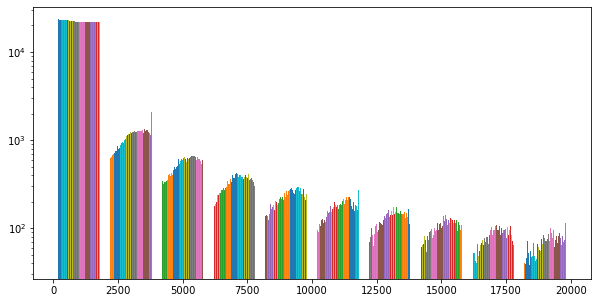

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.hist(x_train)
ax.set(yscale='log')

In [13]:
x_train

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)